This script will start with a baseline CV outputs and apply scenarios of changing habitat distributions by modifying the presence/absence of habitats at specific shore points. Afterward, the overall natural_habitats rank can be re-calculated, and then the coastal_exposure index can be re-calculated. And these habitat scenarios can be summarized by subregions and compared back to the baseline in terms of exposure index or other metrics. 

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import natcap.invest.coastal_vulnerability.coastal_vulnerability_core as cv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

sns.set(font_scale=1.3)

In [1]:
# workspace = '../mpa-removeall-habitat/scenario_data/'

In [2]:
allhabitats = pd.read_csv('../mpa-removeall-habitat/cv-output-invest3.3.0-intacthabitat/outputs/natural_habitats/natural_habitats.csv')

In [3]:
mpahabitats = pd.read_csv('../mpa-removeall-habitat/cv-output-invest3.3.0/outputs/natural_habitats/natural_habitats.csv')

In [4]:
# there are inexplicable null values for copp, pine, mang habitats in this table:
# national_shp = gpd.read_file('/home/dmf/bahamas-mpa/cv/cv-fromjess/CV_Bahamas_112316_GV/CV_Bahamas_JMS.shp')
# but there are not null values in this version:
national_shp = gpd.read_file('/home/dmf/bahamas-mpa/cv/cv-fromjess/CV_Bahamas_snappedPts.shp')

### Find and remove habitats from points protected by habitat within MPAs

In [5]:
# order the habitats to match list(mpahabitats)
habitat_shore = national_shp[['x', 'y', 'copp_rank', 'mang_rank',  'sgr_rank01', 'cor_rank01', 'pine_rank']]

In [6]:
habitat_shore_update = pd.DataFrame()

In [7]:
def find_remove_habitat(habstring1, habstring2):
    habitat_match = allhabitats[habstring1] == mpahabitats[habstring1]
    hab_ind = habitat_match[habitat_match == False].index
    xydf = mpahabitats[['x', 'y']].iloc[hab_ind]
    print('LENGTH hab index', len(hab_ind))
    
    # need to find points influenced by habitats from these 2 runs
    # in the existing national results. 
    # can match on 'x' and 'y' columns, but they are floats
    # best to round them first
    xys = zip(xydf['x'].round(3), xydf['y'].round(3))
    habitat_shore['x3'] = habitat_shore['x'].round(3)
    habitat_shore['y3'] = habitat_shore['y'].round(3)
    
    print('OLD COUNTS')
    print(habitat_shore[habstring2].value_counts())
    
    def find_points_update_rank(r):
    #     print (r['x'], r['y'])
        if (r['x3'], r['y3']) in xys:
            r[habstring2] = 0
        return r
    
    outdf = habitat_shore.apply(axis=1, func=find_points_update_rank)
    
    print('NEW COUNTS')
    print(outdf[habstring2].value_counts())
    
#     habitat_shore_update[habstring2] = outdf[habstring2]
    
    return outdf[habstring2]

In [8]:
for h1, h2 in zip(list(mpahabitats)[4:9], list(habitat_shore)[2:7]):
    print(h1, h2)
    habitat_shore_update[h2] = find_remove_habitat(h1, h2)

('HAB_03_DenseMangroveandCoppice_influence_on_shore', u'copp_rank')
('LENGTH hab index', 6218)
OLD COUNTS
1    22199
0     5059
Name: copp_rank, dtype: int64


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NEW COUNTS
1.0    16229
0.0    11029
Name: copp_rank, dtype: int64
('HAB_12_SwampSparseMangrove_influence_on_shore', u'mang_rank')
('LENGTH hab index', 7402)
OLD COUNTS
3    16797
0     8828
1     1633
Name: mang_rank, dtype: int64
NEW COUNTS
0.0    16229
3.0    10529
1.0      500
Name: mang_rank, dtype: int64
('HAB_06_Seagrass_influence_on_shore', u'sgr_rank01')
('LENGTH hab index', 7218)
OLD COUNTS
4.0    15512
0.0    11746
Name: sgr_rank01, dtype: int64
NEW COUNTS
0.0    18643
4.0     8615
Name: sgr_rank01, dtype: int64
('HAB_15_ShallowCoral_influence_on_shore', u'cor_rank01')
('LENGTH hab index', 2466)
OLD COUNTS
0.0    17583
1.0     9675
Name: cor_rank01, dtype: int64
NEW COUNTS
0.0    19406
1.0     7852
Name: cor_rank01, dtype: int64
('HAB_09_Pine_influence_on_shore', u'pine_rank')
('LENGTH hab index', 240)
OLD COUNTS
0    23650
2     3608
Name: pine_rank, dtype: int64
NEW COUNTS
0.0    23890
2.0     3368
Name: pine_rank, dtype: int64


In [9]:
habitat_shore_update.head()

,copp_rank,mang_rank,sgr_rank01,cor_rank01,pine_rank
0,1.0,0.0,4.0,0.0,0.0
1,1.0,0.0,4.0,0.0,0.0
2,1.0,0.0,4.0,0.0,0.0
3,1.0,0.0,4.0,0.0,0.0
4,1.0,0.0,4.0,0.0,0.0


In [159]:
# sns.distplot(habitat_shore_update['mang_rank'])

In [131]:
## testing the logic used in the apply() function by counting number of points found in xys
## looks like it found them all
# i=0
# for r in habitat_shore[['x3', 'y3']].itertuples():
# #     print((r[1], r[2]))
#     if (r[1], r[2]) in xys:
#         i += 1
#         r[3] = 0
# print(i)

6217


### re-compute coastal forest score

In [180]:
# sample_cf = national_shp[['copp_rank', 'mang_rank', 'pine_rank', 'cf_rank01']]

In [10]:
sample_cf.drop_duplicates()

NameError: name 'sample_cf' is not defined

In [11]:
def coastal_forest_rank(x):
    if sum(x) == 0:
        return 0
    else:
        return min(x[x>0])

In [12]:
habitat_shore_update['cf_rank'] = \
habitat_shore_update[['copp_rank', 'mang_rank', 'pine_rank']].apply(axis=1, func=coastal_forest_rank)

In [13]:
# verify results of coastal_forest rank
habitat_shore_update[['copp_rank', 'mang_rank', 'pine_rank', 'cf_rank']].drop_duplicates()

,copp_rank,mang_rank,pine_rank,cf_rank
0,1.0,0.0,0.0,1.0
13,1.0,3.0,0.0,1.0
63,0.0,3.0,0.0,3.0
185,1.0,3.0,2.0,1.0
303,1.0,0.0,2.0,1.0
440,0.0,0.0,0.0,0.0
696,0.0,3.0,2.0,2.0
1021,0.0,1.0,0.0,1.0
1513,0.0,0.0,2.0,2.0
10406,1.0,1.0,2.0,1.0


### re-compute natural_habitats rank

In [14]:
# re-compute natural habitats rank:
def recalc_habindex(x):
    if sum(x) == 0:
        return 5
    else:
        x = x[x != 0]
        return cv.combined_rank(x)


In [15]:
habitat_shore_update['natural_habitats'] = \
habitat_shore_update[['cf_rank', 'sgr_rank01', 'cor_rank01']].apply(axis=1, func=recalc_habindex)

In [16]:
habitat_shore_update.head()

,copp_rank,mang_rank,sgr_rank01,cor_rank01,pine_rank,cf_rank,natural_habitats
0,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
1,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
2,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
3,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
4,1.0,0.0,4.0,0.0,0.0,1.0,1.758619


/usr/lib/pymodules/python2.7/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


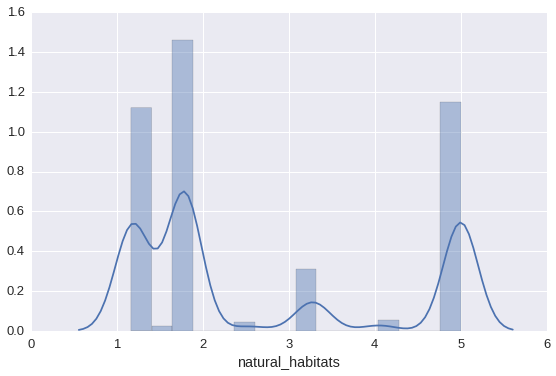

In [17]:
sns.distplot(habitat_shore_update['natural_habitats'])

In [19]:
habitat_shore_update[['x', 'y']] = habitat_shore[['x', 'y']]

In [20]:
habitat_shore_update.head()

,copp_rank,mang_rank,sgr_rank01,cor_rank01,pine_rank,cf_rank,natural_habitats,x,y
0,1.0,0.0,4.0,0.0,0.0,1.0,1.758619,162996.410662,3.019659e+06
1,1.0,0.0,4.0,0.0,0.0,1.0,1.758619,162746.410662,3.019409e+06
2,1.0,0.0,4.0,0.0,0.0,1.0,1.758619,163246.410662,3.019409e+06
3,1.0,0.0,4.0,0.0,0.0,1.0,1.758619,163496.410662,3.019409e+06
4,1.0,0.0,4.0,0.0,0.0,1.0,1.758619,162746.410662,3.019159e+06


In [21]:
habitat_shore_update.to_csv('../mpa-removeall-habitat/scenario_data/mpa-nohabitat-habitatranks.csv', index=False)

### re-compute coastal forest and natural_habitats rank for national results 
(since there was bug in coastal forest rank)

In [32]:
national_shp = gpd.read_file('/home/dmf/bahamas-mpa/cv/cv-fromjess/CV_Bahamas_snappedPts.shp')

In [6]:
national_foresthabs = national_shp[['copp_rank', 'mang_rank', 'pine_rank']]

In [7]:
national_foresthabs['cf_rank'] = \
national_foresthabs.apply(axis=1, func=coastal_forest_rank)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


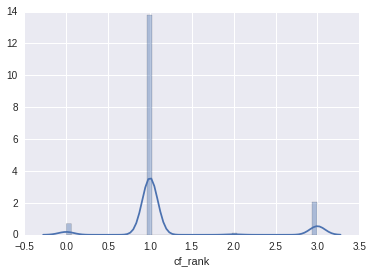

In [8]:
sns.distplot(national_foresthabs['cf_rank'])

In [11]:
national_foresthabs.drop_duplicates()

,copp_rank,mang_rank,pine_rank,cf_rank
0,1,0,0,1
13,1,3,0,1
63,0,3,0,3
185,1,3,2,1
303,1,0,2,1
440,0,0,0,0
696,0,3,2,2
1021,0,1,0,1
1945,1,1,0,1
3563,0,0,2,2


In [33]:
# replace the cf_rank variable in the national dataset:
national_shp['cf_rank01'] = national_foresthabs['cf_rank']

In [34]:
# re-compute natural habitats rank with the new cf_rank:
national_shp['natural_habitats'] = \
national_shp[['cf_rank01', 'sgr_rank01', 'cor_rank01']].apply(axis=1, func=recalc_habindex)

In [39]:
# and make a habitat rank that represents no habitats (all 5s)
national_shp['no_natural_habitats'] = 5

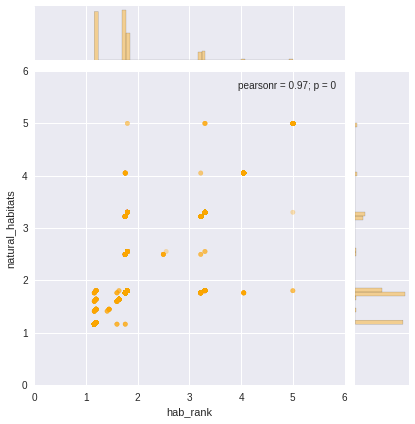

In [17]:
# compare to the old hab_rank, just for qualitative check
sns.jointplot(x='hab_rank', y='natural_habitats', data=national_shp, alpha=0.3, color='orange')

### re-compute exposure index using the new habitat rank, for national results

In [35]:
# first dropping the old hab_rank:
national_shp.drop(axis=1, labels='hab_rank', inplace=True)

In [57]:
# specify variables to include in the exposure index
# these vars were verified to reproduce the 'ei1_chs1' exposure index
# indexvars = ['geomorph', 'elev_01', 'hab_rank', 'wexp_01', 'surge', 'slr_01']
# just swapping in the new natural_habitats rank
basevars = ['geomorph', 'elev_01', 'wexp_01', 'surge', 'slr_01']
indexvars = basevars + ['natural_habitats']

In [59]:
print(indexvars)

['geomorph', 'elev_01', 'wexp_01', 'surge', 'slr_01', 'natural_habitats']


In [22]:
# equation taken from
# natcap.invest.coastal_vulnerability_core.coastal_exposure_index()
def recalculate_exposure(indexvars, data):
    exposure = data[indexvars].apply(axis=1, func=lambda x: np.power(np.prod(x), 1./(x.size)))
    return exposure

In [37]:
national_shp['coast_exp'] = recalculate_exposure(indexvars, national_shp)

In [40]:
indexvars = basevars + ['no_natural_habitats']
national_shp['coast_exp_nohabs'] = recalculate_exposure(indexvars, national_shp)

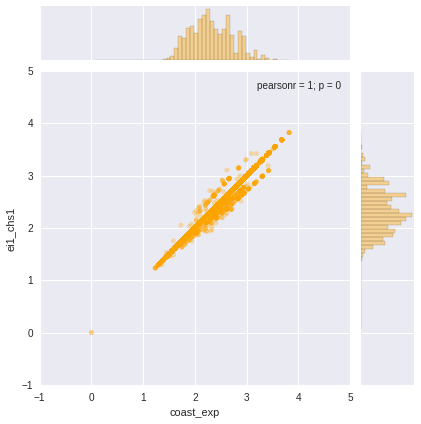

In [38]:
# comparing new exposure index to the original result(which had a bug in the coastal_forest rank)
sns.jointplot(x='coast_exp', y='ei1_chs1', data=national_shp, alpha=0.3, color='orange')

In [ ]:
# view distributions of exposure for 1) 'with all' 2) 'without all'  and 3) 'without mpa' habitats

In [41]:
# attach scenario habitat data to national results and compute coastal exposure indices
mpa_habitat_ranks = pd.read_csv('../mpa-removeall-habitat/scenario_data/mpa-nohabitat-habitatranks.csv')

In [42]:
mpa_habitat_ranks.head()

,copp_rank,mang_rank,sgr_rank01,cor_rank01,pine_rank,cf_rank,natural_habitats
0,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
1,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
2,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
3,1.0,0.0,4.0,0.0,0.0,1.0,1.758619
4,1.0,0.0,4.0,0.0,0.0,1.0,1.758619


In [60]:
national = national_shp[basevars]

In [61]:
national['mpa_hab_rank'] = mpa_habitat_ranks['natural_habitats']

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [62]:
list(national)

[u'geomorph', u'elev_01', u'wexp_01', u'surge', u'slr_01', 'mpa_hab_rank']

In [64]:
indexvars = basevars + ['mpa_hab_rank']
national['nompa_coast_exp'] = recalculate_exposure(indexvars, national)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [74]:
## put all three scenarios in a table with xy
scenarios = pd.DataFrame()
scenarios['ce_all_habitats'] = national_shp['coast_exp']
scenarios['ce_no_habitats'] = national_shp['coast_exp_nohabs']
scenarios['ce_nompa_habitats'] = national['nompa_coast_exp']
# scenarios['geometry'] = national_shp['geometry']
# scenarios['x'] = national_shp['x']
# scenarios['y'] = national_shp['y']

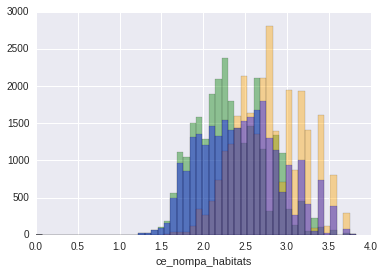

In [71]:
sns.distplot(scenarios['ce_all_habitats'], kde=False, color='green')
sns.distplot(scenarios['ce_no_habitats'], kde=False, color='orange')
sns.distplot(scenarios['ce_nompa_habitats'], kde=False, color='blue')


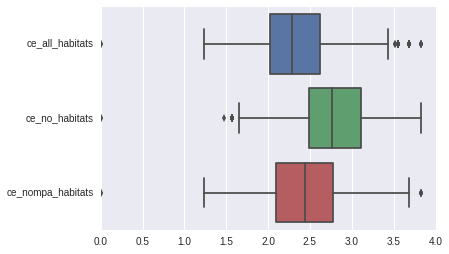

In [73]:
sns.boxplot(scenarios, orient='h')

### assign subregions to points:

In [120]:
subregions = gpd.read_file('/home/dmf/bahamas-mpa/cv/cv-fromjess/Bahamas_regionalCV_Inputs/LandPoly_Bahamas_subregions.shp')

In [121]:
# buffer ensures the land polygons enclose the coastal points, which are a bit offshore
subregions['geometry'] = subregions.buffer(400)

In [137]:
list(subregions)

[u'CROSS_SHLF',
 u'Name',
 u'ORIG_FID',
 u'Subregion',
 'geometry',
 u'sq_meter',
 u'sqmeter_2']

In [138]:
subregions.drop(axis=1, labels=['CROSS_SHLF', 'ORIG_FID', 'Subregion', 'sq_meter', 'sqmeter_2'], inplace=True)

In [125]:
scenarios['fid'] = scenarios.index

In [130]:
scenarios_shp = gpd.GeoDataFrame(scenarios, crs=national_shp.crs, geometry=national_shp.geometry)

In [139]:
pts_in_region = gpd.sjoin(scenarios_shp, subregions, how='inner', op='intersects')

In [143]:
pts_in_region.drop(axis=1, labels='index_right', inplace=True)

In [215]:
type(pts_in_region)

geopandas.geodataframe.GeoDataFrame

In [ ]:
pts_in_region['habrole'] = pts_in_region.ce_nompa_h - pts_in_region.ce_all_hab

In [149]:
pts_in_region.to_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland.shp')

### Categorize exposure indices into high-med-low
using distribution of combined exposure values from multiple scenarios

In [3]:
pts_in_region = gpd.read_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland.shp')

In [4]:
pts_in_region.head()

,Name,ce_all_hab,ce_no_habi,ce_nompa_h,fid,geometry,habrole
0,Abaco,2.435669,3.107233,2.610602,0,POINT (162928.413004 3019466.78567),0.174933
1,Abaco,2.435669,3.107233,2.610602,1,POINT (162853.713287 3019270.52392),0.174933
2,Abaco,2.435669,3.107233,2.610602,2,POINT (163216.047947 3019346.4071),0.174933
3,Abaco,2.435669,3.107233,2.610602,3,POINT (163431.129412 3019247.9762),0.174933
4,Abaco,2.435669,3.107233,2.610602,4,POINT (162849.749416 3019245.02939),0.174933


In [158]:
# drop habrole because we don't want it's values in the distribution of exposure values
longdf = pd.melt(frame=pts_in_region.drop(axis=1, labels='habrole'), id_vars=['geometry', 'fid', 'Name'])

In [163]:
longdf.head()

,geometry,fid,Name,variable,value
0,POINT (162928.413004 3019466.78567),0,Abaco,ce_all_hab,2.435669
1,POINT (162853.713287 3019270.52392),1,Abaco,ce_all_hab,2.435669
2,POINT (163216.047947 3019346.4071),2,Abaco,ce_all_hab,2.435669
3,POINT (163431.129412 3019247.9762),3,Abaco,ce_all_hab,2.435669
4,POINT (162849.749416 3019245.02939),4,Abaco,ce_all_hab,2.435669


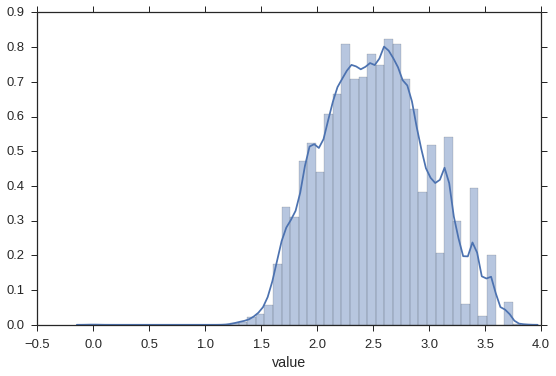

In [164]:
sns.distplot(longdf.value)

In [165]:
quants = longdf.value.quantile([.25, .75])
print(quants)

0.25    2.173805
0.75    2.842598
Name: value, dtype: float64


In [166]:
def categorize_exposure(x):
    if x <= quants.iloc[0]:
        return 'low'
    if quants.iloc[0] < x < quants.iloc[1]:
        return 'med'
    if x >= quants.iloc[1]:
        return 'high'

In [167]:
longdf['category'] = longdf['value'].apply(func=categorize_exposure)

In [168]:
longdf.head()

,geometry,fid,Name,variable,value,category
0,POINT (162928.413004 3019466.78567),0,Abaco,ce_all_hab,2.435669,med
1,POINT (162853.713287 3019270.52392),1,Abaco,ce_all_hab,2.435669,med
2,POINT (163216.047947 3019346.4071),2,Abaco,ce_all_hab,2.435669,med
3,POINT (163431.129412 3019247.9762),3,Abaco,ce_all_hab,2.435669,med
4,POINT (162849.749416 3019245.02939),4,Abaco,ce_all_hab,2.435669,med


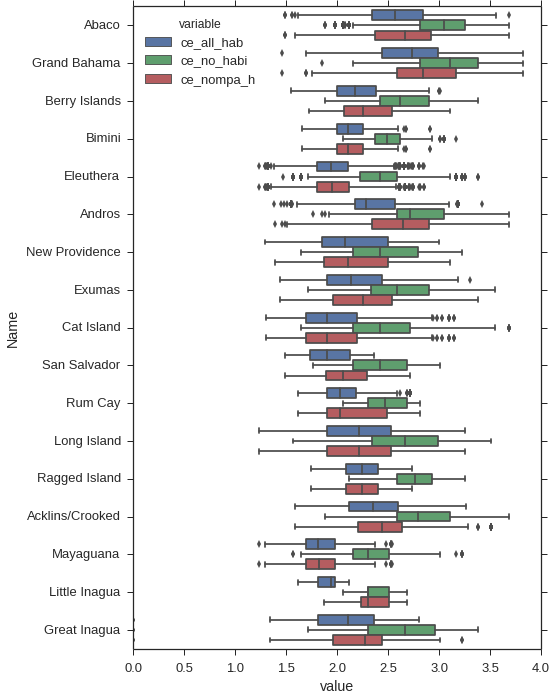

In [169]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 10)
sns.boxplot(x="value", y="Name", hue='variable', data=longdf)
fig.savefig('../figs/cv_scenarios_boxplot_exposure.png')
fig.savefig('../figs/cv_scenarios_boxplot_exposure.svg')

In [146]:
longdf.head()

,geometry,fid,Name,variable,value,category
0,POINT (162928.413004 3019466.78567),0,Abaco,ce_all_hab,2.435669,med
1,POINT (162853.713287 3019270.52392),1,Abaco,ce_all_hab,2.435669,med
2,POINT (163216.047947 3019346.4071),2,Abaco,ce_all_hab,2.435669,med
3,POINT (163431.129412 3019247.9762),3,Abaco,ce_all_hab,2.435669,med
4,POINT (162849.749416 3019245.02939),4,Abaco,ce_all_hab,2.435669,med


In [241]:
longdf.to_csv('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland_category.csv', index=False)

In [242]:
scenario_geo = gpd.GeoDataFrame(longdf, crs=national_shp.crs, geometry=longdf['geometry'])

In [243]:
scenario_geo.to_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland_category.shp')

### Metric 1: Length of coastline in each category, for each island  

In [4]:
scen_geo = gpd.read_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland_category.shp')

In [6]:
scen_geo.head()

,Name,category,fid,geometry,value,variable
0,Abaco,med,0,POINT (162928.413004 3019466.78567),2.435669,ce_all_hab
1,Abaco,med,1,POINT (162853.713287 3019270.52392),2.435669,ce_all_hab
2,Abaco,med,2,POINT (163216.047947 3019346.4071),2.435669,ce_all_hab
3,Abaco,med,3,POINT (163431.129412 3019247.9762),2.435669,ce_all_hab
4,Abaco,med,4,POINT (162849.749416 3019245.02939),2.435669,ce_all_hab


In [7]:
grouped_df = pd.DataFrame(scen_geo.groupby(['Name', 'category', 'variable']).size().rename('npoints'))

In [8]:
coastlength = pd.DataFrame(grouped_df.to_records())

In [9]:
coastlength['km_shore'] = coastlength['npoints']*(0.25)

In [249]:
coastlength.head()

,Name,category,variable,npoints,km_shore
0,Abaco,high,ce_all_hab,1377,344.25
1,Abaco,high,ce_no_habi,3397,849.25
2,Abaco,high,ce_nompa_h,1617,404.25
3,Abaco,low,ce_all_hab,792,198.00
4,Abaco,low,ce_no_habi,61,15.25


In [250]:
coastlength.to_csv('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland_category_kmshore.csv', index=False)

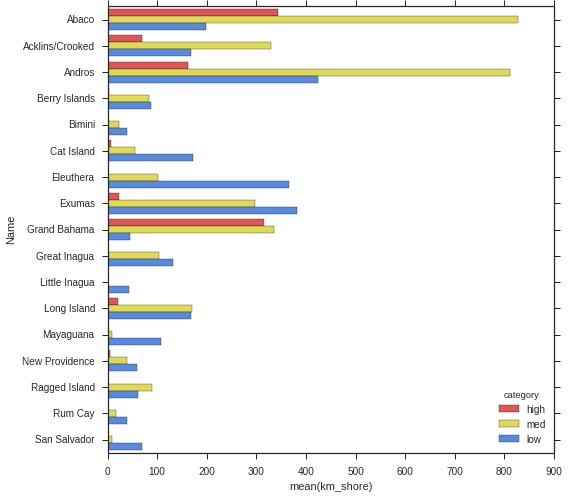

In [253]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='km_shore', 
            hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=coastlength[coastlength.variable == 'ce_all_hab'])
fig.savefig('../figs/cv_shorelength_all_habitats.png')
fig.savefig('../figs/cv_shorelength_all_habitats.svg')

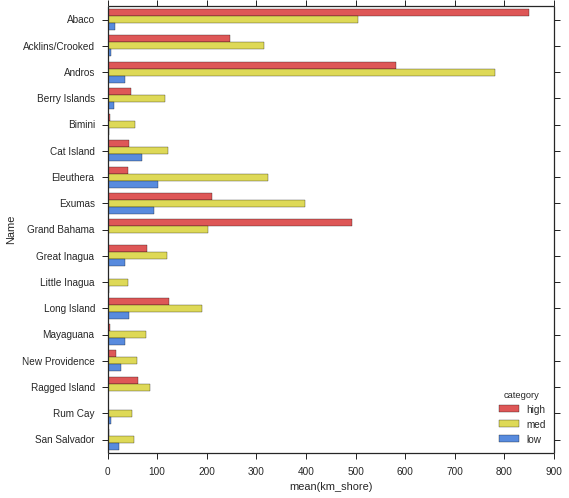

In [255]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='km_shore', 
            hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=coastlength[coastlength.variable == 'ce_no_habi'])
fig.savefig('../figs/cv_shorelength_no_habitats.png')
fig.savefig('../figs/cv_shorelength_no_habitats.svg')

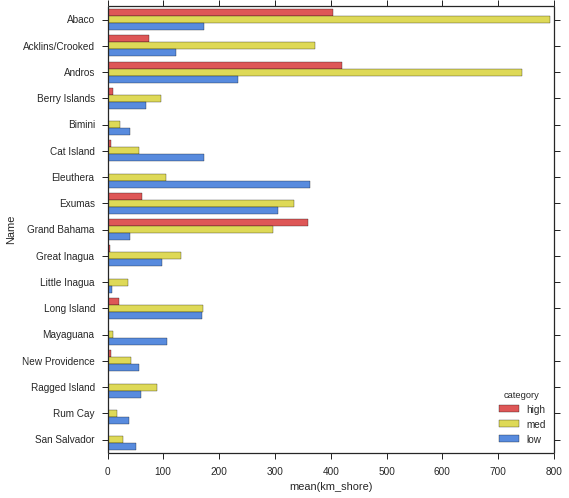

In [256]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='km_shore', 
            hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=coastlength[coastlength.variable == 'ce_nompa_h'])
fig.savefig('../figs/cv_shorelength_nompa_habitats.png')
fig.savefig('../figs/cv_shorelength_nompa_habitats.svg')

#### difference in km_shore between allhab and nompa scenarios

In [172]:
coastlength = pd.read_csv('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland_category_kmshore.csv')

In [173]:
coastlength[coastlength.variable != 'ce_no_habi'].head()

,Name,category,variable,npoints,km_shore
0,Abaco,high,ce_all_hab,1377,344.25
2,Abaco,high,ce_nompa_h,1617,404.25
3,Abaco,low,ce_all_hab,792,198.00
5,Abaco,low,ce_nompa_h,691,172.75
6,Abaco,med,ce_all_hab,3309,827.25


In [174]:
coastlength.drop(axis=1, labels='npoints', inplace=True)

In [8]:
widecoast = coastlength[coastlength.variable != 'ce_no_habi'].pivot_table(index=['Name', 'category'], columns='variable', values='km_shore')

In [179]:
widecoast['diff_km'] = widecoast.ce_nompa_h - widecoast.ce_all_hab

In [180]:
widecoast.reset_index(inplace=True)

In [30]:
widecoast.to_csv('../mpa-removeall-habitat/scenario_data/cv_2scenarios_byisland_category_diffkmshore.csv')

In [37]:
widecoast[['Name', 'category', 'diff_km']].loc[widecoast.category == 'high'].to_html('../figs/cv_shorelength_diff_nompa-allhab_table.html', index=False)

In [12]:
widecoast[['Name', 'category', 'diff_km']].loc[widecoast.category == 'high']

variable,Name,category,diff_km
0,Abaco,high,60.00
3,Acklins/Crooked,high,3.75
6,Andros,high,257.25
9,Berry Islands,high,7.50
12,Bimini,high,0.00
15,Cat Island,high,-0.50
18,Eleuthera,high,0.00
21,Exumas,high,37.75
24,Grand Bahama,high,44.75
27,Great Inagua,high,NaN


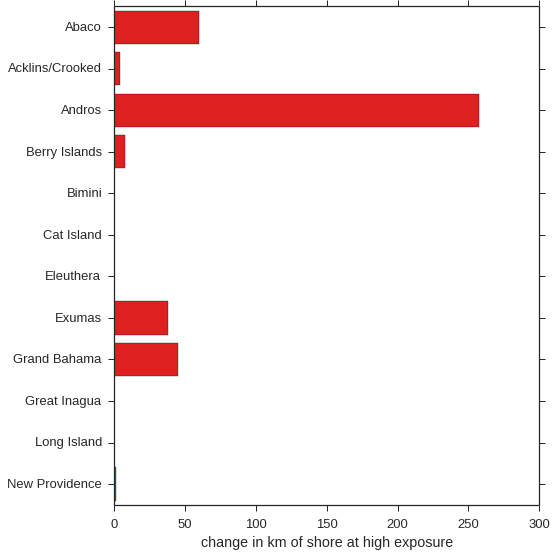

In [133]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
# cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diff_km', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=widecoast[['Name', 'category', 'diff_km']].loc[widecoast.category == 'high'])

ax.set(xlabel='change in km of shore at high exposure', 
       ylabel='', xlim=(0, 300))


fig.savefig('../figs/cv_shorelength_diff-high_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_shorelength_diff-high_nompa-allhab.svg)

In [322]:
# def diff_km_shore(x):
#     try:
# #         print(len(x['km_shore']))
#         km_all = x['km_shore'][:1]
#         km_nompa = x['km_shore'][1:2]
#         print(km_all)
#         print(km_nompa)
#         return {x['Name'][:1]:km_all - km_nompa}
#     except(KeyError):
#         print('keyerr')

In [22]:
# test = coastlength[coastlength.variable != 'ce_no_habi'].groupby(['Name', 'category']).apply(diff_km_shore)

### Metric 2: zonal stats for population metrics  

In [17]:
scen_geo = gpd.read_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_byisland_category.shp')

In [18]:
scen_geo.head()

,Name,category,fid,geometry,value,variable
0,Abaco,med,0,POINT (162928.413004 3019466.78567),2.435669,ce_all_hab
1,Abaco,med,1,POINT (162853.713287 3019270.52392),2.435669,ce_all_hab
2,Abaco,med,2,POINT (163216.047947 3019346.4071),2.435669,ce_all_hab
3,Abaco,med,3,POINT (163431.129412 3019247.9762),2.435669,ce_all_hab
4,Abaco,med,4,POINT (162849.749416 3019245.02939),2.435669,ce_all_hab


In [265]:
scen_geo['geometry'] = scen_geo.buffer(1000)

In [266]:
island_cats_geo = scen_geo.dissolve(by=['Name', 'category', 'variable'], as_index=False)

In [269]:
island_cats_geo.crs = scen_geo.crs

In [270]:
island_cats_geo.to_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_isl_cat_1kmbuf.shp', )

#### now do the zonalstats

In [19]:
import rasterstats as rs

In [20]:
island_cats_geo = gpd.read_file('../mpa-removeall-habitat/scenario_data/cv_3scenarios_isl_cat_1kmbuf.shp', )

In [60]:
def zonal_pop_stats(geodf, raster_path, prefix):
    pop_stats = rs.zonal_stats(geodf, raster_path, 
                           geojson_out=True, prefix=prefix,
                          stats=['sum'],
                          all_touched=True)
    pop_stats_gdf = gpd.GeoDataFrame.from_features(pop_stats)
    return pop_stats_gdf

In [61]:
popdf = zonal_pop_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/pop_int2.tif', 'pop_')
more65df = zonal_pop_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/more65.tif', 'more65_')
incdf = zonal_pop_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/totinc.tif', 'inc_')

In [ ]:
popdf.drop(axis=1, labels='value', inplace=True)

In [64]:
incdf.head()

,Name,category,fid,geometry,inc_sum,value,variable
0,Abaco,high,5,"(POLYGON ((481248.659205 2435894.45251, 481243...",13616264.00,2.842598,ce_all_hab
1,Abaco,high,0,"(POLYGON ((622429.8413296185 2395884.63459429,...",82664200.00,3.107233,ce_no_habi
2,Abaco,high,18,"(POLYGON ((622429.8413296185 2395884.63459429,...",14797805.00,2.901948,ce_nompa_h
3,Abaco,low,398,"(POLYGON ((482164.523032 2434808.39993, 482159...",58146688.00,2.169935,ce_all_hab
4,Abaco,low,5229,"(POLYGON ((488498.455355 2578157.45413, 488493...",1061186.75,2.154435,ce_no_habi


In [67]:
popmetrics = pd.concat([popdf, more65df.more65_sum, incdf.inc_sum], axis=1)

In [68]:
popmetrics.head()

,Name,category,fid,geometry,pop_sum,variable,more65_sum,inc_sum
0,Abaco,high,5,"(POLYGON ((481248.659205 2435894.45251, 481243...",1486.0,ce_all_hab,80.380608,13616264.00
1,Abaco,high,0,"(POLYGON ((622429.8413296185 2395884.63459429,...",9020.0,ce_no_habi,498.262451,82664200.00
2,Abaco,high,18,"(POLYGON ((622429.8413296185 2395884.63459429,...",1619.0,ce_nompa_h,88.448120,14797805.00
3,Abaco,low,398,"(POLYGON ((482164.523032 2434808.39993, 482159...",6383.0,ce_all_hab,363.251740,58146688.00
4,Abaco,low,5229,"(POLYGON ((488498.455355 2578157.45413, 488493...",115.0,ce_no_habi,9.353016,1061186.75


In [45]:
# pop_stats = rs.zonal_stats(island_cats_geo, '../cv-fromjess/SocialMetrics_GV/pop_int2.tif', 
#                            geojson_out=True, prefix='pop_',
#                           stats=['min', 'max', 'mean', 'sum', 'count'],
#                           all_touched=True)

In [46]:
# pop_stats_gdf = gpd.GeoDataFrame.from_features(pop_stats)

In [69]:
# pop_stats_gdf.head()

In [92]:
def pivot_and_diff(x, valuestring):
    df = x[x.variable != 'ce_no_habi']
    wide = df.pivot_table(index=['Name', 'category'], columns='variable', values=valuestring)
    diffstr = 'diff' + valuestring
    wide[diffstr] = wide.ce_nompa_h - wide.ce_all_hab
    per_ch_str = 'per_ch_' + valuestring
    wide[per_ch_str] = (wide[diffstr]/wide.ce_all_hab)*100
    wide.reset_index(inplace=True)
#     print(wide.head())
    widehigh = wide[wide.category == 'high']
    return widehigh

In [93]:
widepop = pivot_and_diff(popdf, 'pop_sum')
widemore65 = pivot_and_diff(more65df, 'more65_sum')
wideinc = pivot_and_diff(incdf, 'inc_sum')

In [94]:
widepop.head()

variable,Name,category,ce_all_hab,ce_nompa_h,diffpop_sum,per_ch_pop_sum
0,Abaco,high,1486.0,1619.0,133.0,8.950202
3,Acklins/Crooked,high,42.0,42.0,0.0,0.000000
6,Andros,high,44.0,62.0,18.0,40.909091
9,Berry Islands,high,0.0,42.0,42.0,inf
12,Bimini,high,NaN,NaN,NaN,NaN


In [48]:
# widepop = popdf[popdf.variable != 'ce_no_habi'].pivot_table(index=['Name', 'category'], columns='variable', values='pop_sum')

In [70]:
# widepop = popmetrics[popmetrics.variable != 'ce_no_habi'].pivot_table(index=['Name', 'category'], 
#                                                                       columns='variable', 
#                                                                       values=['pop_sum', 'more65_sum', 'inc_sum'])

In [79]:
# widepop.head()

In [49]:
# widepop['diff_pop'] = widepop.ce_nompa_h - widepop.ce_all_hab
# widepop['perch_pop'] = (widepop.diff_pop/widepop.ce_all_hab)*100

In [50]:
# widepop.reset_index(inplace=True)

In [51]:
# widepophigh = widepop[widepop.category == 'high']

In [100]:
widepop

variable,Name,category,ce_all_hab,ce_nompa_h,diffpop_sum,per_ch_pop_sum
0,Abaco,high,1486.0,1619.0,133.0,8.950202
3,Acklins/Crooked,high,42.0,42.0,0.0,0.000000
6,Andros,high,44.0,62.0,18.0,40.909091
9,Berry Islands,high,0.0,42.0,42.0,inf
12,Bimini,high,NaN,NaN,NaN,NaN
15,Cat Island,high,46.0,46.0,0.0,0.000000
18,Eleuthera,high,64.0,64.0,0.0,0.000000
21,Exumas,high,375.0,584.0,209.0,55.733333
24,Grand Bahama,high,1831.0,1999.0,168.0,9.175314
27,Great Inagua,high,NaN,0.0,NaN,NaN


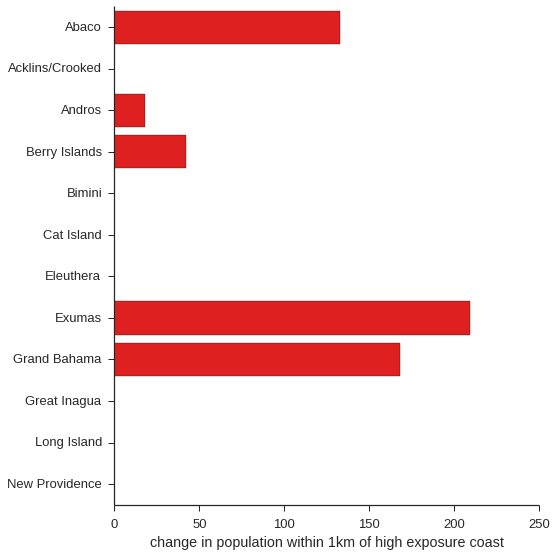

In [190]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
# cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])
sns.despine()

sns.barplot(y='Name', x='diffpop_sum', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=widepop)

ax.set(xlabel='change in population within 1km of high exposure coast', ylabel='')
# ,
#       xlim=(-300, 300))

fig.savefig('../figs/cv_population_diff_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_population_diff_nompa-allhab.svg)

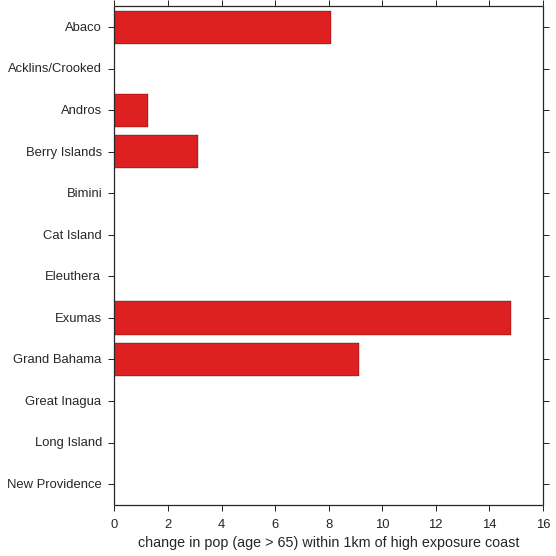

In [135]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diffmore65_sum', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=widemore65)

ax.set(xlabel='change in pop (age > 65) within 1km of high exposure coast', ylabel='')
# ,
#       xlim=(-300, 300))

fig.savefig('../figs/cv_popover65_diff_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_popover65_diff_nompa-allhab.svg', dpi=150)

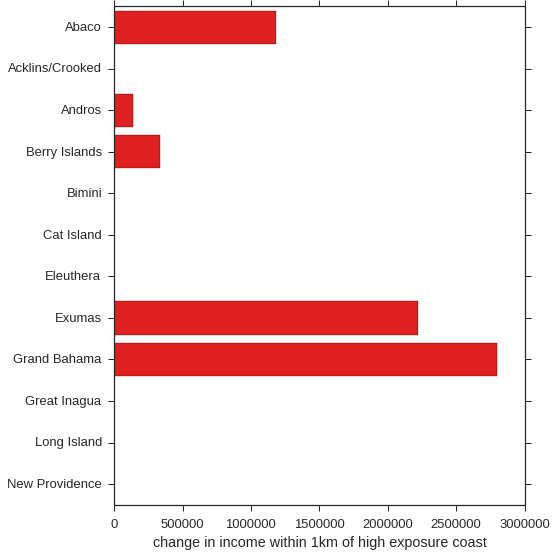

In [136]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diffinc_sum', color='red',
#             hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=wideinc)

ax.set(xlabel='change in income within 1km of high exposure coast', ylabel='')
# ,
#       xlim=(-300, 300))

fig.savefig('../figs/cv_income_diff_nompa-allhab.png', dpi=150)
fig.savefig('../figs/cv_income_diff_nompa-allhab.svg)

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#f44141', '#f4ee41', '#4286f4'])

sns.barplot(y='Name', x='diff_km', 
            hue='category', palette=cmap, hue_order=['high', 'med', 'low'], 
            data=pop_stats_gdf)

ax.set(xlabel='change in km of shore', ylabel='',
      xlim=(-300, 300))

fig.savefig('../figs/cv_shorelength_diff_nompa-allhab.png')
fig.savefig('../figs/cv_shorelength_diff_nompa-allhab.svg')

In [ ]:
# put island levels on points
# put categories on points
# slice by island, then by category and
# buffer and dissolve points, calc zonal stats on the population rasters
# also want km of coastline (aka number of points) in each category, for each island


In [75]:
scenarios.to_csv('../mpa-removeall-habitat/scenario_data/national_cv_3scenarios.csv')

In [77]:
geo_df = gpd.GeoDataFrame(scenarios, crs=national_shp.crs, geometry=national_shp.geometry)

In [78]:
geo_df.to_file('../mpa-removeall-habitat/scenario_data/national_cv_3scenarios.shp')

In [79]:
# put the above code into a function that can work on each habitat,
# re-compute the coastal forest score after that
# re-compute habitat rank
# re-compute exposure index
# summarize change in EI by island
# summarize change in # of people by island